# Computer Lab: nonnegative matrix factorization

<b> Student : </b> Ahlem JOUIDI

In [84]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
import scipy.sparse
import scipy.sparse.linalg

<b>Database : </b> The database of faces, collected by AT&T Laboratories Cambridge, on https://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html.

### Q1 : How many images are there in the database? How many pixels are there in each image?

There are 400 photos in the dataset. The size of each photo is 92x112.

In [86]:
def build_matrix_from_faces(folder='orl_faces', minidata=False):
    # load images
    # 400 images of size (112, 92)
    M = []
    if minidata is True:
        nb_subjects = 1
    else:
        nb_subjects = 40
    for subject in range(1, nb_subjects + 1
                        ):
        for image in range(1, 11):
            face = plt.imread(folder + '/s' + str(subject)
                              + '/' + str(image) + '.pgm')
            M.append(face.ravel())

    return np.array(M, dtype=float)

def vectorize(W, H):
    return np.concatenate((W.ravel(), H.ravel()))

def unvectorize_M(W_H, M):
    # number of elements in W_H is (n+p)*k where M is of size n x m
    # W has the nk first elements
    # H has the kp last elements
    n, p = M.shape
    k = W_H.shape[0] // (n + p)
    W = W_H[:n * k].reshape((n, k))
    H = W_H[n * k:].reshape((k, p))
    return W, H

Download the database at https://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html
Uncompress the file.

In [87]:
# Small data to test the algorithm
M = build_matrix_from_faces(folder='orl_faces', minidata=True)
def unvectorize(W_H): return unvectorize_M(W_H, M)
k = 2

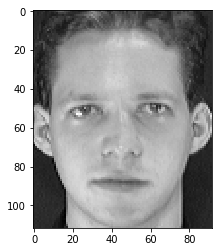

In [88]:
# To see the first face:
plt.imshow(M[0].reshape((112, 92)), cmap='gray'); plt.show()

In [92]:
# Full data
M = build_matrix_from_faces(folder='orl_faces', minidata=False)
def unvectorize(W_H): return unvectorize_M(W_H, M)
k = 38
n = M.shape[0]
p = M.shape[1]

### Question 2.1 Show that the objective function is not convex. Calculate its gradient. Is the gradient Lipschitz continuous?

Convexity of f : 
    We will give a countre-example that does not verify the convex inequality: 
let's assume that n = m = k = 1.  $$ \\ $$ Let f be the objective function. Let  $ X = (W_1, H_1) $, Y = $(W_2, H_2)$ and t= 1/2.   $$ $$  Assume that $ W_1 = 0 , H_1 = 0. $  
We have:  


$$  f ( t X + (1-t) Y)  = f  ( (  t W_1 + (1-t) W_2  , t H_1  + (1-t) H_2 ) ) =   || M- t  (1-t) \times  W_2 H_1 ||^2  .$$


Now assume that $ W_2 $ = 8 and $ H_1 $ = 5, M=1  
we get that  $$ || ( M- t (1-t)   W_2 H_1 ||^2   = 81. $$
On the other side we have $$ t  f(X) + (1-t)  f(Y) =  || M || = 1. $$
Finally we get that $$ f(t \times X + (1-t) \times Y) > t \times f(X) + (1-t) \times f(Y) $$ Which contradicts the convex inequality. 

 Gradient of f
Calculate the gradient of the objective function :
Let's calculate 
$$ \frac{ \mathbf ||M-W*(H+ \delta H)||^2 }{2np} = \frac{ tr( (M-W(H+ \delta H)) (M-W(H- \delta H))^t ) }{2np} \\
                               =\frac{ tr( ((M-WH) - \delta W)H) ((M-WH) - \delta W)H)^t )}{2np} \\
                               = \frac{ tr ( (M-WH)(M-WH)^t ) - 1/np \times tr( (M-WH)( W \delta H)^t ) + o(\mathbf \delta H)}{2np} \\
                               = \frac{tr ( (M-WH)(M-WH)^t ) - 1/np \times tr( W^t (M-WH), \delta H^t)  + o(\mathbf \delta H)}{2np} $$

Using The Fundamental Theorem of the Calculus of Finite Differences 
$$ f(x+\delta x) - f(x) = <\delta f(x) , \delta x> + o(\mathbf \delta x) $$                            

By identification we can set :
$$ f(W,H)=  \frac{tr ( (M-WH)(M-WH)^t )}{2np} $$
$$ \Delta w f(W,H) =  \frac{ (WH-M)H^t}{np}$$

And by the same way, we calculate $$ \frac{ \mathbf ||M-(W+ \delta W)H||^2}{2np} $$ we have 
$$ \Delta _H f(W,H) = \frac{  W^t (M-WH)}{np} $$


## 3 Find W when H0 is fixed

We initialize the optimization algorithm as follows:

    W0, S, H0 = scipy.sparse.linalg.svds(M, k)
    W0 = numpy.maximum(0, W0 * numpy.sqrt(S))
    H0 = numpy.maximum(0,(H0.T * numpy.sqrt(S)).T)


### Q 3.1 What is the advantage of this choice? What would be other possibilities for the initial-ization?

 We see that the gradient is of degree 3 (in W and H). 
Therefore, the gradient of  $ f $ is not Lipschitz-continuous.

In [139]:
W0, S, H0 = scipy.sparse.linalg.svds(M, k)
W0 = np.maximum(0, W0 * np.sqrt(S))
H0 = np.maximum(0,(H0.T * np.sqrt(S)).T)


The singular value decomposition gives  2 matrices, Just like the form of the problem. 
Taking the coeficiens as Max(0, W) ensures W > 0 and the zeros make it a sparse matrix.  This means that we are reducing the number of parameters and simplifying calculations.

### Question 3.2 Is the objective function g convex? Calculate its gradient. We will admit that the gradient of g is Lipschitz continuous with constant L0 = k(H0)>H0kF .


$g$ is now a convex function. $\forall$  a nonnegative matrix W with size $ n \times k $:   $$  $$ 
$$ g(W)=\frac{\left || M -WH_0\right ||^2}{2np}$$ 
$\forall W$ , $g(W)=\frac{\left | M -WH_0\right |^2}{2np}$$= \frac{\sum_{i=1}^{n}\sum_{j=1}^{p} (M_{i,j}-\sum_{l=1}^{k} W_{i,l}H_{0_{l,j}})^2}{2np}$$=   \frac{\sum_{i=1}^{n}\sum_{j=1}^{p} M_{i,j}^2-2M_{i,j}\sum_{l=1}^{k} W_{i,l}H_{0_{l,j}} +(\sum_{l=1}^{k} W_{i,l}H_{0_{l,j}})^2}{2np}\\ $. 
The function can be decomposed as the sum of convex functions $ \Rightarrow $  $g$ is convex.

$g(W+h)=\frac{\left | M -WH_0\right |^2}{2np}=\frac{\langle\,M-WH_0-hH_0,M-WH_0-hH_0\rangle}{2np}=\frac{\left | M -WH_0\right |^2-2\langle\,M-WH_0,hH_0\rangle + o(\left | h\right |^2) }{2np}=\frac{\left | M -WH_0\right |^2-2\langle\,(M-WH_0)H_0^T,h\rangle + o(\left | h\right |^2) }{2np} $.
$$$$
Therefore, $ \triangledown g(W) = \frac{-(M-WH_0)H_0^T}{np}$

### Question 3.3 Write a function to compute g(W) and another to compute rg(W).
You can check your computations using the function scipy.optimize.check grad (as
check grad cannot deal with matrix variable, you may need to vectorize your variables).

In [140]:
def G(W):
    return (1/(2*n*p) * (np.linalg.norm((M - np.dot(W, H0)),'fro'))**2)
print ('G(W0)=',G(W0))
def dG(W):
    temp = (M - np.dot(W, H0))
    ans = -(1/(n*p) * np.dot(temp, H0.T))
    return ans
print('dG(W0)',dG(W0))

G(W0)= 878.916653181886
dG(W0) [[0.01641867 0.01647908 0.0194469  ... 0.06766629 0.03723525 0.23410547]
 [0.00977077 0.01440896 0.01382352 ... 0.02895313 0.05931482 0.30704021]
 [0.01783746 0.0187198  0.01649104 ... 0.04621488 0.05621137 0.2548014 ]
 ...
 [0.01705013 0.0186659  0.02259787 ... 0.03190761 0.04121826 0.32110996]
 [0.01011337 0.01420269 0.01461199 ... 0.02038143 0.02568511 0.18979599]
 [0.01330702 0.01398558 0.01635192 ... 0.02120499 0.03551692 0.25846626]]


### Question 3.4 Show that for all $ \xi > 0 $ , prox(R+) is the projection onto R+.
Let's compute $ prox_{\varsigma _{\mathbb{R_+}}} $ $$ p = prox_{\varsigma _{\mathbb{R_+}}} (x) \Leftrightarrow p \in \underset{y \in \mathbb{R}}{argmin}(\varsigma _{\mathbb{R_+}} + \frac{\left \| y-x \right \|^2}{2}) \Leftrightarrow p \in \underset{y \in \mathbb{R_+}}{argmin}(\left \| y-x \right \|^2) \Leftrightarrow $$  p is the projection onto $\mathbb{R_+}$. Since $\gamma \varsigma _{\mathbb{R_+}} =\varsigma _{\mathbb{R_+}}$, then we have that $ prox_{\varsigma _{\mathbb{R_+}}} = prox_{\gamma \varsigma _{\mathbb{R_+}}} $.

### Question 3.5 Code a function projected gradient method(val g, grad g, W0, gamma, N) that mini-mizes a function g subject to nonnegativity constraints by the projected gradient method with a constant step size  , starting from W0 and stopping after N iterations.

We minimize g under nonnegativity constraints $ \Leftrightarrow x_{k+1} = proj_{M_{\mathbb{R_+}}} (x_k - \gamma \triangledown g(x_k))$


In [151]:
def proj (x):
    for i in range (x.shape[0]):
         x[i] = np.maximum(0, x[i])
    return x
def projected_gradient_method(G, dG, W0, gamma, N):
    mini = []
    for i in range (N):
        W0 = proj(W0 - gamma * dG(W0))
        mini.append(G(W0))
    return (mini)   
        

### Question 3.6 Use the function to minimize g with N = 100.

In [152]:
L0 = np.linalg.norm(np.dot(H0.T, H0), "fro")    
gamma=1/L0
N=100
cur_w= projected_gradient_method(G, dG, W0, gamma, N)
print('The fixed step size is', 1/L0)
print ('The objective function calculated with w0',G(W0))
print("The local minimum occurs at", cur_w[N-1])


The fixed step size is 3.464699897517404e-06
The objective function calculated with w0 878.916653181886
The local minimum occurs at 878.9017060289473


## 4 Algorithmic refinement for the problem with H0 fixed

### Question 4.1 Implement a line search to the projected gradient method, in order to free ourselves from the need of a known Lipschitz constant.

 To search the optimal step gamma at eatch iteration, we have to determine $ \gamma $ that minimize $$ f(\gamma)=g(W_k-\gamma \Delta g(W_k)) $$
 So the probleme is one dimmensional optimization problem.
 $$ f(\gamma)=g(W_k-\gamma \Delta g(W_k)) =  \frac{ tr ( (M- \gamma \Delta g(W_k)H_0) (M- \gamma \Delta g(W_k)H_0)^t)}{2np} \\ $$
 Let's calculate $$ \frac{ \delta f}{\delta \gamma}    
    =  \frac{ 2 tr ( (M- W_k H_0) (\Delta g(W_k)H_0)^t ) + 2 \gamma tr( \Delta g(W_k)H_0 H_0^t \Delta g(W_k)^t)}{2np} $$ 
 then to have the minimiser 
    $$   \frac{ \delta f}{\delta \gamma}  = 0$$
     $$  tr( (M- W_k H_0) (\Delta g(W_k)H_0)^t ) = \gamma tr( \Delta g(W_k) H_0 H_0^t \Delta g(W_k)^t) \\ $$
   
 finally we get
   $$ \gamma = \frac{tr ( ( W_k H_0-M) (\Delta g(W_k)H_0)^t ) }{\gamma tr( \Delta g(W_k)H_0 H_0^t \Delta g(W_k)^t)} $$
    

In [104]:
def line_search(W0,M,H0,dG):
    p1=np.dot(dG(W0),H0)
    p2=np.dot(W0,H0)
    gamma=(np.dot(p2,p1.T).trace()-np.dot(M,p1.T).trace())/np.dot(p1,p1.T).trace()
    return gamma
print('The first step size is', line_search(W0,M,H0,dG))


The first step size is 14.571382300986286


### Question 4.2 Compare the performance of both algorithms.

In [154]:
def proj (x):
    for i in range (x.shape[0]):
         x[i] = np.maximum(0, x[i])
    return x

def projected_gradient_method_optimal_step(G, dG, W0,  N):
    mini=[]
    for i in range (N):
        gamma=line_search(W0,M,H0,dG)
        W0 = proj(W0 - gamma * dG(W0))
        mini.append(G(W0))
    return (mini)   

N=100    
cur_w1= projected_gradient_method_optimal_step(G, dG, W0,  N)
print('The local minimum is ',cur_w1[N-1])  

The local minimum is  474.61077982214107


In [ ]:
# plt.plot(np.arange(0, N, 1), cur_w, '-b', label= 'PGM')
plt.plot(np.arange(0, N, 1), cur_w1, '-g', label = 'Line Search')
plt.legend(loc='upper left')
plt.show()

## 5 Resolution of the full problem

### Question 5.1 Solve Problem (1) by the projected gradient method with line search for N = 1000 iterations. What does the algorithm return?

In [125]:
N = 1000
v1000 = projected_gradient_method_optimal_step(G, dG, W0, N)
print(v1000[N-1])

-4.092186145188135


### Question 5.2 Show that the value of the objective in decreasing at each iteration. Deduce from this that the value converges.

Let:

$ W_{t} = arg min_{W} \frac{1}{2np} \left\lVert M - W H_{t-1} \right\rVert  $

$ H_{t} = arg min_{H} \frac{1}{2np} \left\lVert M - W_{t} H \right\rVert  $

We will compare $f(x-1)$ and $f(x)$ , it is clear that f is positive (f is defined as a norm) so we can compare its square root

by the definition of $arg min_{W}$ we have that: $ \frac{1}{\sqrt2np} \left\lVert M - W_{t}H_{t} \right\rVert \leq \frac{1}{\sqrt2np} \left\lVert M - W_{t}H_{t-1} \right\rVert $


also by the definition of $arg min_{H}$ we have: $ \frac{1}{\sqrt2np} \left\lVert M - W_{t}H_{t-1} \right\rVert \leq \frac{1}{\sqrt2np} \left\lVert M - W_{t-1}H_{t-1} \right\rVert $


Final we have: $ \frac{1}{\sqrt2np} \left\lVert M - W_{t}H_{t} \right\rVert \leq \frac{1}{\sqrt2np} \left\lVert M - W_{t-1}H_{t-1} \right\rVert $

As conclusion, we have that f is positive + decreasing ==> it converges


### Question 5.3 Code the alternate minimizations method.

In [160]:
def G1(W, H):
    return (1/(2*n*p) * (np.linalg.norm((M - np.dot(W, H)),'fro'))**2)
def dG_W(W, H):
    temp = (M - np.dot(W, H))
    ans = -(1/(n*p) * np.dot(temp, H.T))
    return ans
def dG_H(W, H):
    temp = (M - np.dot(W, H))
    ans = -(1/(n*p) * np.dot(W.T, temp))
    return ans

In [161]:
def alternate_minimization (G1, dG_w, dG_H, gamma, W, H, N):
    results = []
    for i in range (N):
        W = proj(W - gamma * dG_W(W, H))
        H = proj(H - gamma * dG_H(W, H))
        results.append(G1(W, H))
    return results

### Question 5.4 Compare projected gradient and alternate minimizations methods. Are the solutions the same? Is the objective value the same? How do the computing times compare?

In [162]:
N = 100
vAlternateMinimization = alternate_minimization (G1, dG_w, dG_H, 1/L0, W0, H0, N)

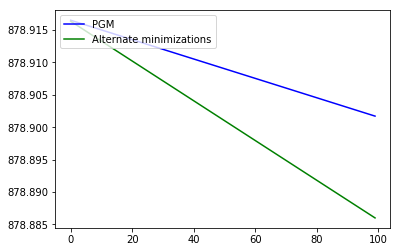

Project gradient method with fixed step: 878.9017060289473
Alternate minimizations: 878.8859911639315


In [165]:
plt.plot(np.arange(0, N, 1), cur_w, '-b', label= 'PGM')
plt.plot(np.arange(0, N, 1), vAlternateMinimization, '-g', label = 'Alternate minimizations')
plt.legend(loc='upper left')
plt.show()
print('Project gradient method with fixed step:', cur_w[N-1])
print('Alternate minimizations:', vAlternateMinimization[N-1])

From the graph, we can see that the minimizations method has better results. The alternate method converge slowly than the alternate method (having higher computing time).
So to optimize our program, we have to use the preojected gradient to have better performance.


### Question 5.5 What stopping criterion could be used for the algorithms instead of just the number of iterations?

The stopping critereon might be : $$\\$$
     the gradient is close enough to zero. $$ ||\Delta f(x_k)|| <= \epsilon $$ 
     the sequence $ x_k $ is almost stationary   $$f(x_k) - f(x_k+1) <= \epsilon $$
where $\epsilon$ is a given parametre   